In [1]:
import copy
import numpy as np
import pprint

from evo.core import trajectory
from evo.tools import file_interface
from evo.tools import plot
from evo.core import metrics
# # temporarily override some package settings
# from evo.tools.settings import SETTINGS
# SETTINGS.plot_usetex = False

# plot.apply_settings(SETTINGS)

import matplotlib.pyplot as plt

In [2]:
gt_traj_file = "/scratch/rohit_jayanti/indoor-topo-loc/hloc_experiments/torwic_eval_trajectory/torwic_sfm_superpoint_inloc_superpoint+lightglue_netvlad_exhaustive_sfm_superpoint+lightglue_down3/gt_image_right_poses.txt"
pred_traj_file = "/home/kumaraditya_gupta/DPVO/saved_trajectories/image_right.txt"

gt_traj = file_interface.read_kitti_poses_file(gt_traj_file)
pred_traj = file_interface.read_tum_trajectory_file(pred_traj_file)

print("GT trajectory shape:", gt_traj.positions_xyz.shape)
print("Predicted trajectory shape:", pred_traj.positions_xyz.shape)

GT trajectory shape: (379, 3)
Predicted trajectory shape: (1136, 3)


In [3]:
# Number of points to sample. ASSUMING gt has fewer points than pred
num_points = gt_traj.positions_xyz.shape[0]

# Indices to sample - using linspace to generate evenly spaced indices
indices = np.linspace(0, pred_traj.positions_xyz.shape[0] - 1, num=num_points, dtype=int)

# Sampling the positions and orientations
sampled_positions = pred_traj.positions_xyz[indices, :]
sampled_orientations = pred_traj.orientations_quat_wxyz[indices, :]

# Create a new trajectory with the downsampled data
downsampled_pred_traj = trajectory.PosePath3D(positions_xyz=sampled_positions, orientations_quat_wxyz=sampled_orientations)

# Print to confirm the shapes match now and alignment was attempted
print("Downsampled predicted trajectory shape:", downsampled_pred_traj.positions_xyz.shape)
print("GT trajectory shape:", gt_traj.positions_xyz.shape)
print("Alignment successful.")


Downsampled predicted trajectory shape: (379, 3)
GT trajectory shape: (379, 3)
Alignment successful.


In [28]:
EYEBALL_SCALE = 1.2

pred_traj_aligned = copy.deepcopy(downsampled_pred_traj)
pred_traj_aligned.align_origin(gt_traj)
pred_traj_aligned.align(gt_traj, correct_scale=True, correct_only_scale=False)
pred_traj_aligned.scale(EYEBALL_SCALE)

# translate the predicted trqjectory by given offset
offset = np.array([-5, 2.5, 0])
offset_matrix = np.eye(4)
offset_matrix[:3, 3] = offset

pred_traj_aligned.transform(offset_matrix)

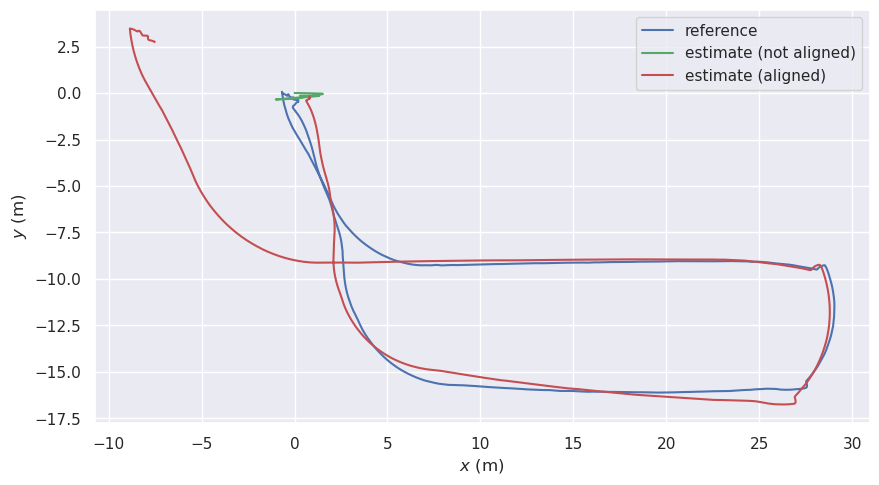

In [29]:
%matplotlib inline

fig = plt.figure(figsize=(10, 20))
traj_by_label = {
    "reference": gt_traj, 
    "estimate (not aligned)": downsampled_pred_traj,
    "estimate (aligned)": pred_traj_aligned,
    # "estimate (aligned and scaled w/gt)": traj_est_scaled_aligned,
}

plot.trajectories(fig, traj_by_label, plot.PlotMode.xy)
plt.show()

{'max': 8.888142355441037,
 'mean': 3.337865388042344,
 'median': 1.4169393331278592,
 'min': 0.30882680170778354,
 'rmse': 4.567600946090621,
 'sse': 7907.068814633886,
 'std': 3.1179533437876943}


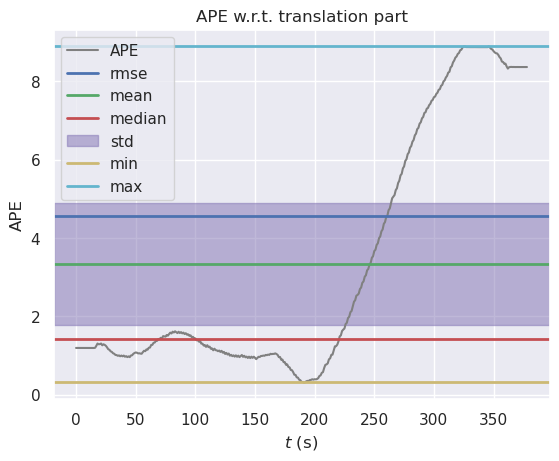

In [30]:
pose_relation = metrics.PoseRelation.translation_part
use_aligned_trajectories = True

if use_aligned_trajectories:
    data = (gt_traj, pred_traj_aligned) 
else:
    data = (gt_traj, downsampled_pred_traj)

ape_metric = metrics.APE(pose_relation)
ape_metric.process_data(data)

ape_stats = ape_metric.get_all_statistics()
pprint.pprint(ape_stats)

START_POSE = 0
END_POSE = gt_traj.positions_xyz.shape[0]
# create an x array with the time in seconds corresponding to each pose
seconds_from_start = list(range(START_POSE, END_POSE))

fig = plt.figure()
plot.error_array(fig.gca(), ape_metric.error, x_array=seconds_from_start,
                statistics={s:v for s,v in ape_stats.items() if s != "sse"},
                name="APE", title="APE w.r.t. " + ape_metric.pose_relation.value, xlabel="$t$ (s)")
plt.show()

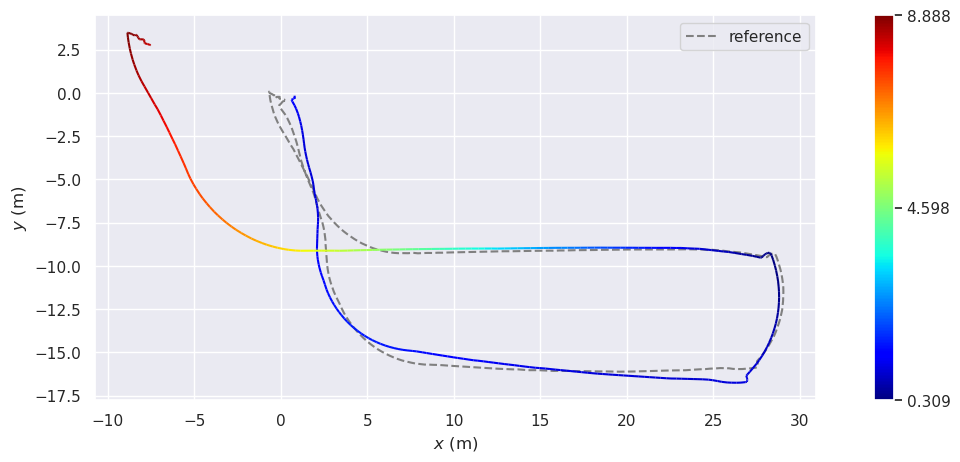

In [31]:
plot_mode = plot.PlotMode.xy
fig = plt.figure(figsize=(15, 5))
ax = plot.prepare_axis(fig, plot_mode)
plot.traj(ax, plot_mode, gt_traj, '--', "gray", "reference")
plot.traj_colormap(ax, pred_traj_aligned if use_aligned_trajectories else downsampled_pred_traj, ape_metric.error, plot_mode, min_map=ape_stats["min"], max_map=ape_stats["max"])
ax.legend()
plt.show()